In [1]:
import copy
import numpy as np
import pandas as pd
import geopandas as gpd
import statistics
import scipy as sp
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx

import math
import geopy.distance





In [2]:
from sklearn_extra.cluster import KMedoids # or from sklearn.cluster
from tslearn.metrics import dtw
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

In [4]:
# for basemaps
#import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

# Analysis using cities as initial divisions

## read necessary files
## coordinates of the regions (cities, microregions, etc)
## shapefile of the regions

### coordinates is a n by 2 array where the i'th entry is the coordinates of the i'th city [x, y]
### adjacency is a n by n array where the ij'th entry is the weight of the vector from city i to city j
###  both of coordinates and adjacency are given as numpy arrays
### method should be 'sum' or 'mean'




In [6]:
#read shapefile of the cities
gdf_cities= gpd.read_file('polygon_shapefiles/cities/31MUE250GC_SIR.shp')
#make a column including region number
gdf_cities['city_index'] = gdf_cities.index

#make the united boundary of the whole region using one of the shapfile
gdf_boundary= gdf_cities.dissolve()

### coordinates is a n by 2 array where the i'th entry is the coordinates of the i'th city [x, y]
with open("Coordinates/Coordinates_cities.pkl", "rb") as f:
    coordinates_cities= pickle.load(f)
    

In [6]:
with open("C:/sima/flow_papers_from_thesis/Coordinates_cities.pkl", "rb") as f:
    coordinates_cities= pickle.load(f)
    
    #boundry dataset
gdf= gpd.read_file('C:\sima\PhD\Thesis\Mg_dataset/31MUE250GC_SIR.shp')
#gdf= gpd.read_file(r'C:\sima\PhD\Brazilian_Data\mg_municipios\MG_total_boundry-shapefile\th878nx5786.shp')
gdf_b= gpd.read_file(r'C:\sima\PhD\Brazilian_Data\mg_municipios\MG_total_boundry-shapefile\th878nx5786.shp')
points_list= find_n_points_on_boundry(gdf_b, n=100)

dg = gpd.read_file(r'C:\sima\PhD\Thesis\Mg_dataset/31MUE250GC_SIR.shp')
dg['city_num'] = dg.index  # Assign city index
#boundary datset
#gdf_b= 

## Paramethers

In [7]:
MW = 12 #number of months
mw = 12
number_cities= len(gdf_cities)

years=['2013', '2014', '2015', '2016']

## Generate vector fields 
### for defined unites (cities) from OD matrices and save them

In [19]:
# import functions
%run Generate_vector_fields.ipynb

In [26]:
vectors_flow_map_cities={}
for y in years:
    vectors_flow_map_cities[y]= {}
    for m in range(mw):
        with open( "OD_matrices/OD_matrices_cities/OD_{}".format(y) + "_{}.pkl".format(m+1), "rb") as f:
            adj_matrix = pickle.load(f)
            
            
        method= 'mean'
        vecs, coords= generate_vector_for_defined_regions(adj_matrix, gdf_boundary, coordinates_cities, method)
            
        vectors_flow_map_cities[y][m+1]= vecs
            
        with open("generated_vector_fields/flow_map_cities_{}".format(y) + "_{}.pkl".format(m+1), "wb") as f:
            pickle.dump(vecs, f)
            


## read the vector fileds that have been generated

In [27]:
vectors_flow_map_cities= {}
for y in years:
    vectors_flow_map_cities[y]= {}
    for m in range(mw):
        with open("generated_vector_fields/flow_map_cities_{}".format(y) + "_{}.pkl".format(m+1), "rb") as f:
            vecs = pickle.load(f)
            vectors_flow_map_cities[y][m+1]= vecs

## Visualise vector fields on map - Flow map visualisation

#### plot vectors with different length and same color

853 853 853 853


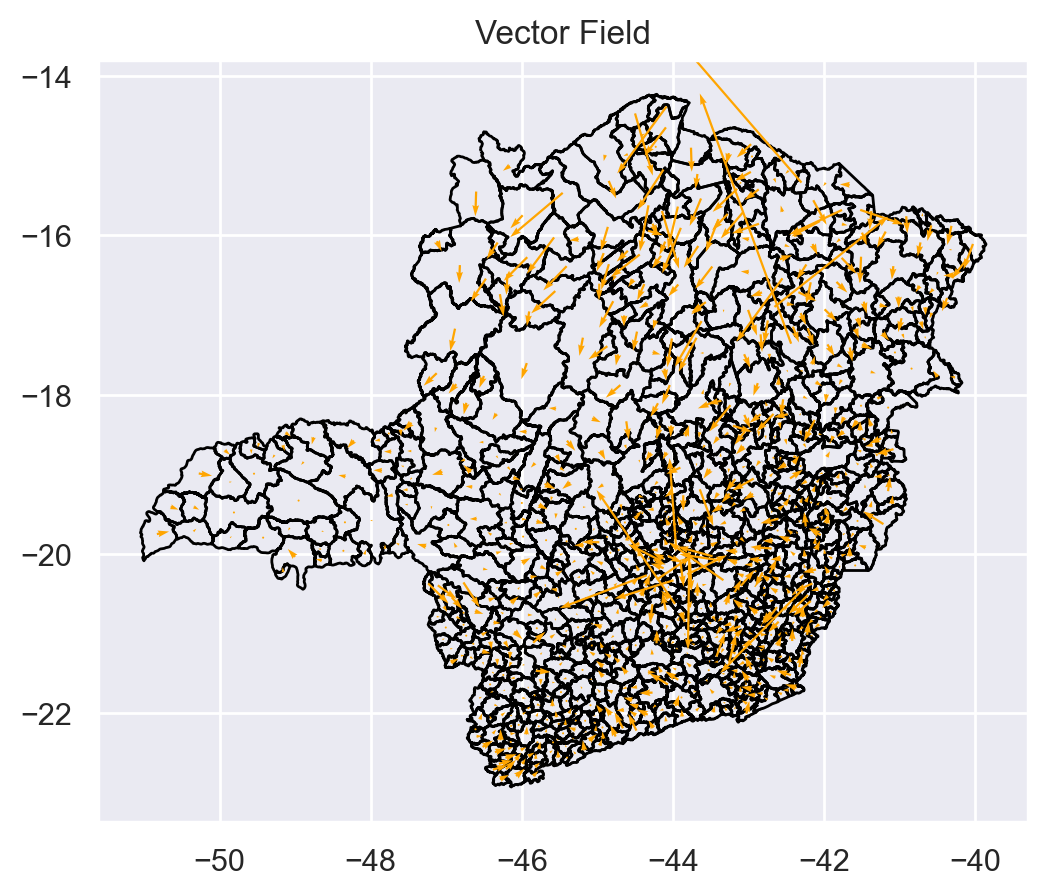

In [114]:
vector_one_month= vectors_flow_map_cities['2013'][1]

X = pd.DataFrame(coordinates_cities)[0].values
Y = pd.DataFrame(coordinates_cities)[1].values

U = [x[0]/5 for x in vector_one_month]
V = [x[1]/5 for x in vector_one_month]

print(len(X),len(Y),len(U),len(V))

# create the quiver plot
fig, ax  = plt.subplots(figsize=(6, 6), dpi=200)

gdf_cities.plot(ax=ax, edgecolor='black', color='None')
ax.quiver(X, Y, U, V, scale=1, units='xy', color='orange')
# ax.gca().set_aspect('equal')


# Display the plot
plt.title('Vector Field')
plt.show()


##### plot vectors with the same length and different colors where colors demonstrates the vector size

## Entropy calculation

In [103]:
# import functions
%run entropy_calculation_function.ipynb

In [54]:
entropy_dictionary_cities = calculate_entropy(vectors_flow_map_cities, years, number_cities, mw=mw, n_label=4)

C:\Users\sf3v23\AppData\Local\Temp\ipykernel_7808\897279969.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu').reversed()


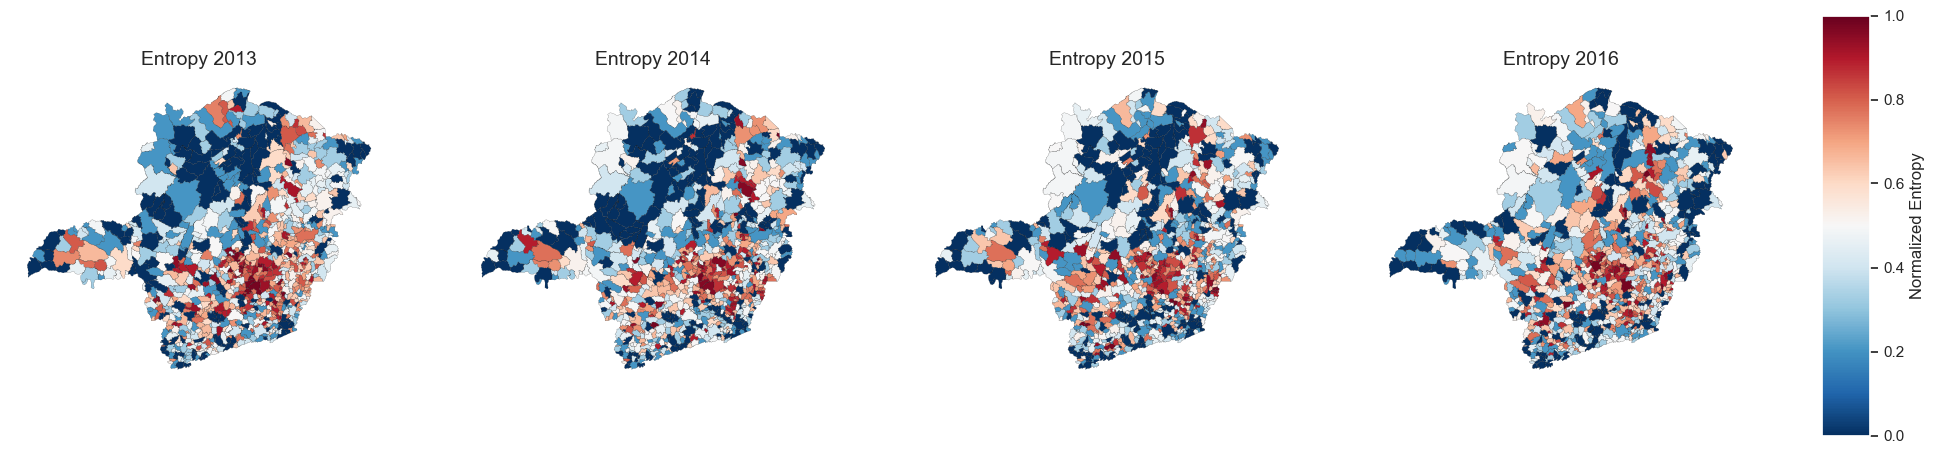

In [104]:
plot_normalized_entropy_maps(gdf_cities, entropy_dictionary_cities, years, city_col='city_index', save_path='plots/entropy_months.jpg')

## calculate cosine similarity

In [61]:
# import functions
%run Cosine_similarity_function.ipynb

In [ ]:
""" import necessary libraries
from sklearn_extra.cluster import KMedoids
from tslearn.metrics import dtw
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter """

In [57]:
# Collect all city vectors in order across all years
vector_city_months_list = []

for ye in years:
    vector_city_months_list.append(np.stack(list(vectors_flow_map_cities[ye].values()), axis=-1))

# Concatenate along the month axis to create a (number_regions, 2, total_months) array
vectors_city_months = np.concatenate(vector_city_months_list, axis=-1)


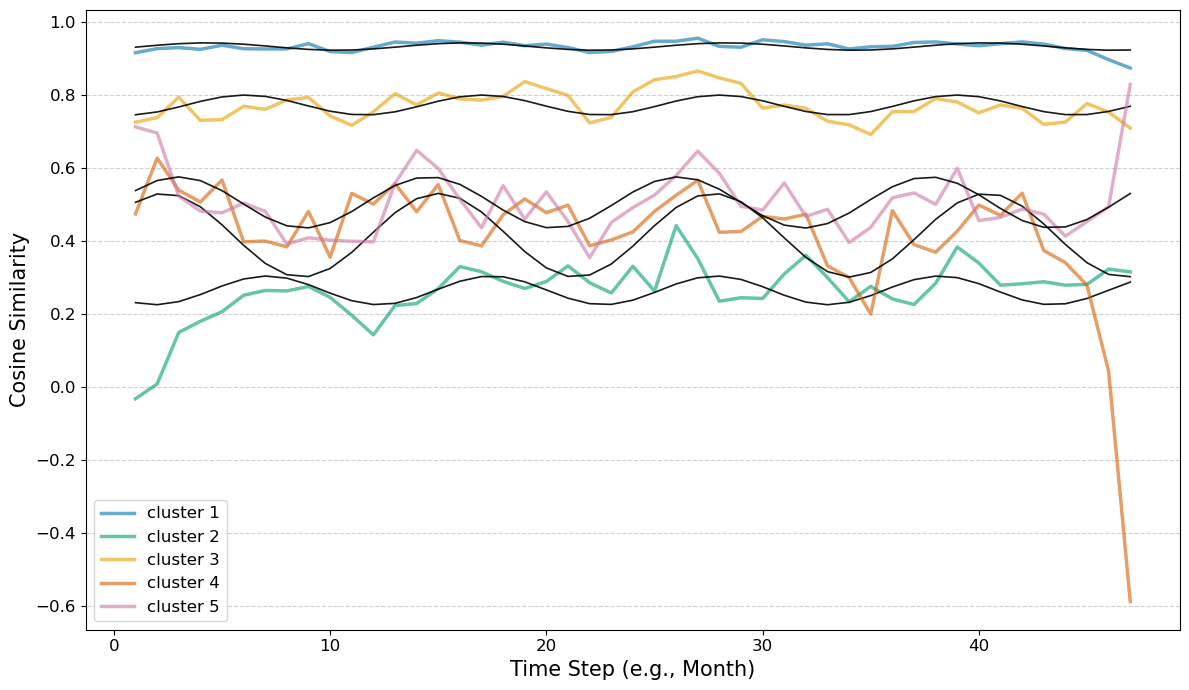

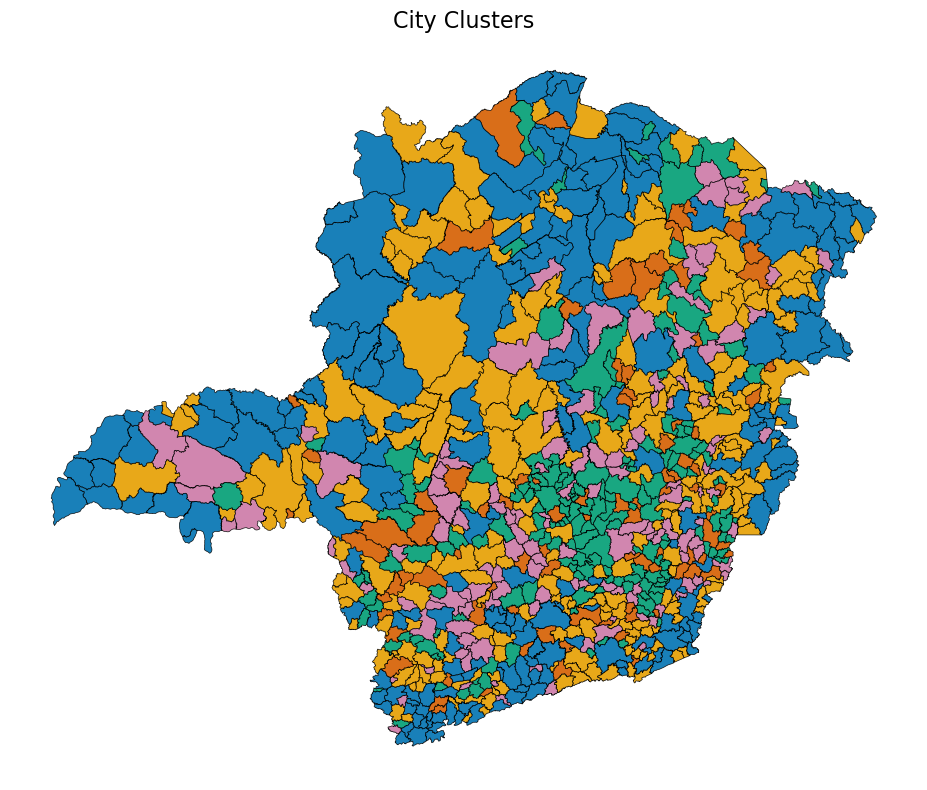

In [62]:
#Compute cosine similarity across the full 4-year period

vector_months_city_cosine_similarity = calculate_cosine_sim(vectors_city_months)


#calculate the distances between the cosine similarity values for the months for the regions
distance_matrix= calculate_dtw_distance_matrix(vector_months_city_cosine_similarity)

#cluster the regions(cities) based on the distance matrix
#select how many clusters you are interested to get
n_clusters=5
clusters, kmedoids= perform_kmedoids_clustering(distance_matrix, n_clusters)

#calculate the mean of the cosine similarity values of the regions(cities) in each clusters
clusters_mean= calculate_cluster_means(vector_months_city_cosine_similarity, clusters)

#plot clusters mean cosine similarity values for months and fit a curve
#assign color for clusters
cluster_colors = {
    0: "#0072b2",
    1: "#009e73",
    2: "#e69f00",
    3: '#d55e00',
    4:'#cc79a7'
}

plot_combined_cluster_trends(clusters_mean, cluster_colors, save_path='plots/CS_clusters_time_series.jpg', savgol_window=7, savgol_order=3)


plot_cluster_map(gdf_cities, clusters, cluster_colors, cluster_id_col='cluster_id', city_num_col='city_index', 
                 save_path='plots/CS_clusters_map.jpg')



# Spatial autocorrelation, Moran's I (global), and spatial lag

In [64]:
# import functions
%run Spatial_autocorrelation_Morans_I_functions.ipynb

In [70]:
#take vector field of one month
vector_one_month= vectors_flow_map_cities['2013'][6]

#calculate  spatial weights matrix here we use queen method
wq= calculate_spatial_weights(gdf_cities, method='queen')

#add vector sizes to gdf file as a column named 'vector_size'
gdf_cities= add_vector_size_to_gdf(gdf_cities, vector_one_month)

#calculate spatial lag and add it to gdf as column named 'spatial_lag'
gdf_cities= calculate_spatial_lag(gdf_cities, 'vector_size', wq)

#calculate Moran's I
# put variable interested to calculate spatial lag and Moran'I - here is vector sizes
y = gdf_cities.vector_size

#calculate Moran's I
moran_calculation = Moran(y, wq)
print(moran_calculation.I)

C:\Users\sf3v23\AppData\Local\Temp\ipykernel_7808\456545210.py:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(gdf)


0.2103111483950317


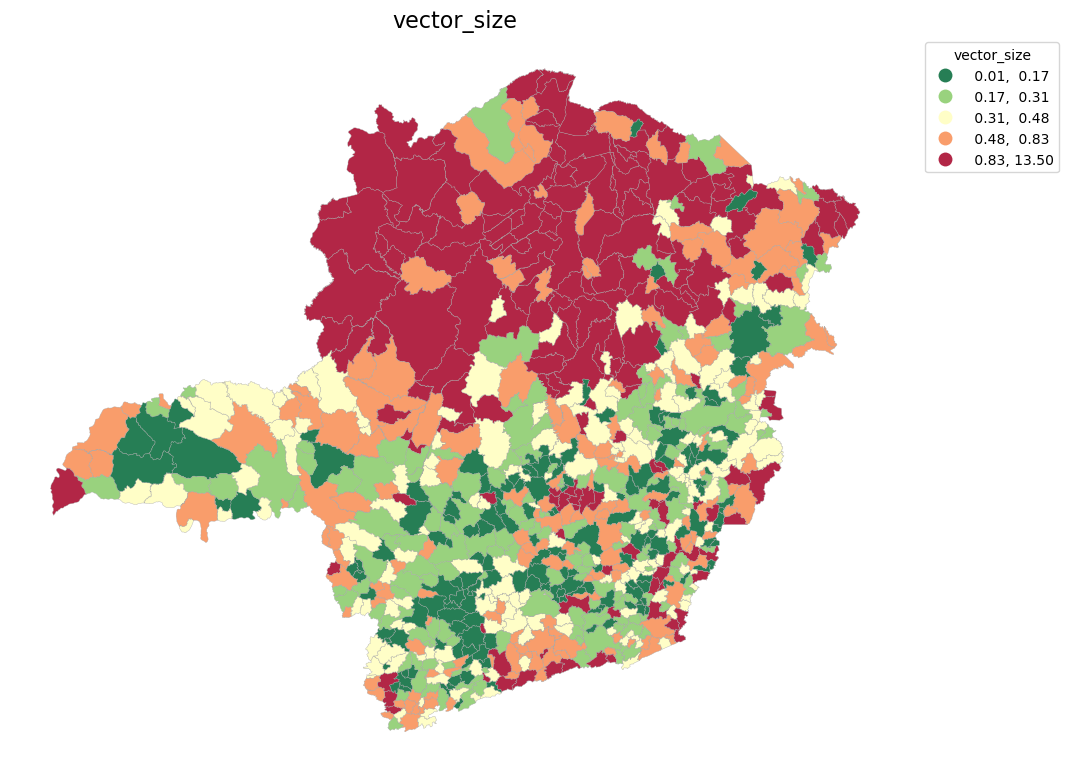

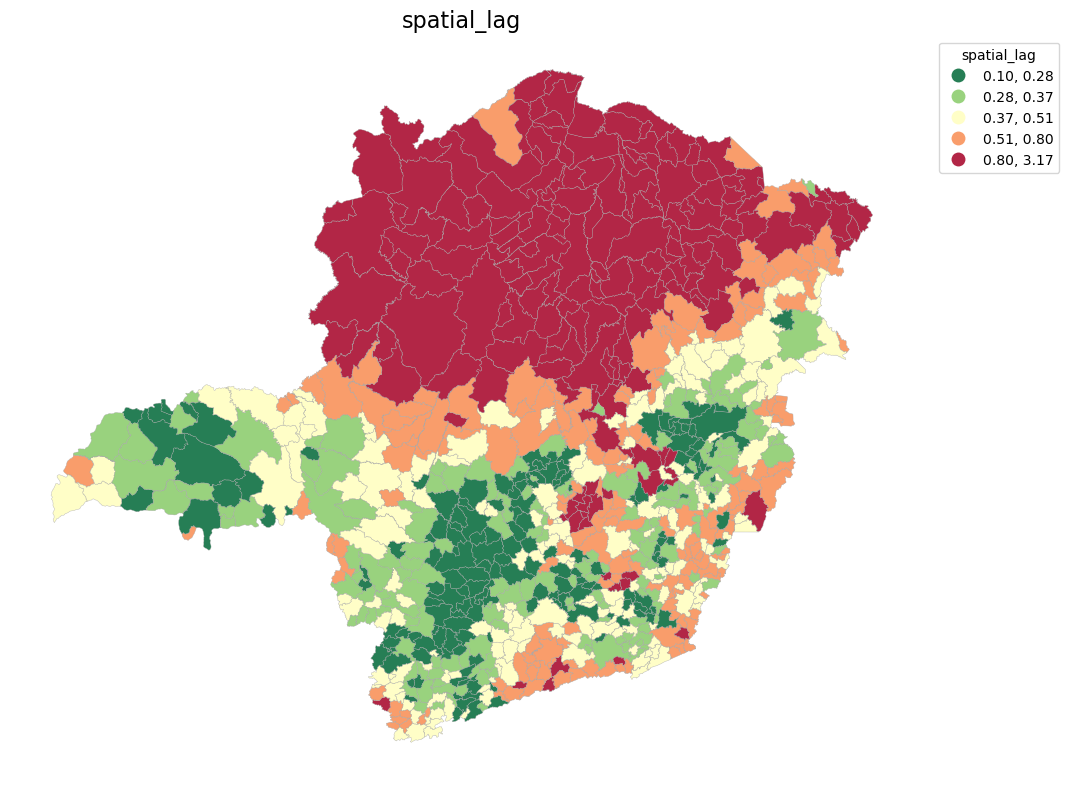

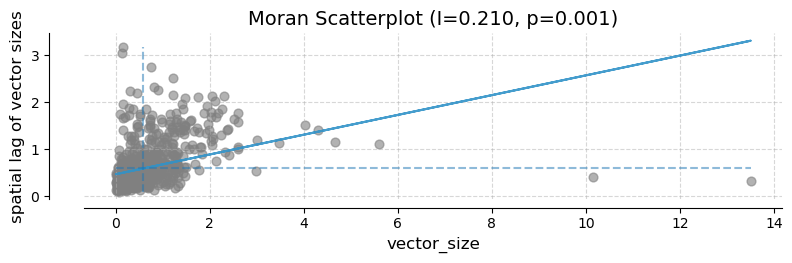

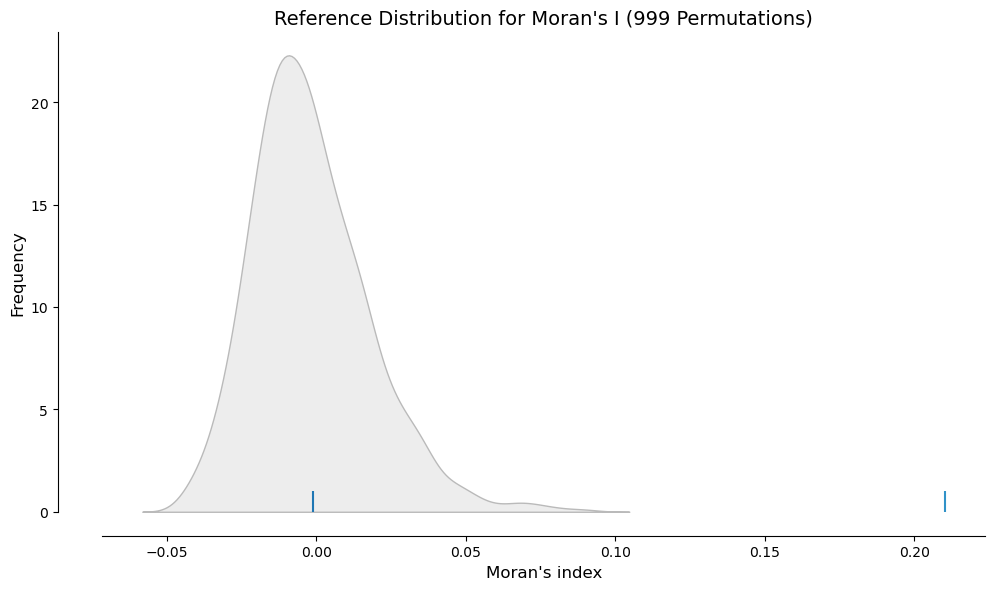

In [71]:
# plot heatmaps of vector sizes and spatial lag
"""scheme='quantiles' gives the same number of cities in each range"""
plot_variable_heatmap(gdf_cities, 'vector_size', title='vector_size', cmap='RdYlGn_r' , save_path='plots/vector_size_map.jpg')
plot_variable_heatmap(gdf_cities, 'spatial_lag', title='spatial_lag', cmap='RdYlGn_r', save_path='plots/spatial_lag_map.jpg')


#Plot Moran's I plots
plot_moran_scatterplot(moran_calculation, save_path='plots/moran_scatter_plot.jpg')
plot_moran_simulation_distribution(moran_calculation, save_path='plots/moran_simulation_distribution.jpg')

In [74]:
# Calculate Moran's I for all monthly vector fields for four years and plot them 

#calculate  spatial weights matrix here we use queen method
wq= calculate_spatial_weights(gdf_cities, method='queen')

moran_months={}
for ye in years:
    moran_months[ye]={}
    for mo in range(mw):
        vector_one_month= vectors_flow_map_cities[ye][mo+1]
        
        #add vector sizes to gdf file as a column named 'vector_size'
        gdf_cities= add_vector_size_to_gdf(gdf_cities, vector_one_month)

        #calculate spatial lag and add it to gdf as column named 'spatial_lag'
        gdf_cities= calculate_spatial_lag(gdf_cities, 'vector_size', wq)

        #calculate Moran's I
        # put variable interested to calculate spatial lag and Moran'I - here is vector sizes
        y = gdf_cities.vector_size

        #calculate Moran's I
        moran_calculation = Moran(y, wq)
        
        I= moran_calculation.I
        moran_months[ye][mo+1]=I
    
#plot the heatmap of the moran's values


C:\Users\sf3v23\AppData\Local\Temp\ipykernel_7808\456545210.py:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(gdf)


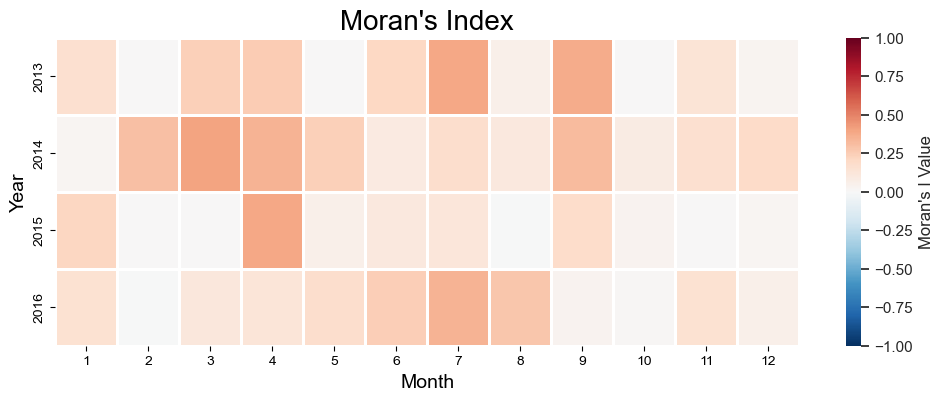

In [75]:
#plot the heatmap of the moran's values
months = list(range(1,13))
years = ['2013', '2014', '2015', '2016']

# Create the data array
moran_array = np.array([[moran_months[year][month] for month in months] for year in years])

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 4))

# Plot heatmap
sns.set(font_scale=1)
ax.set_facecolor('white')
heatmap = sns.heatmap(
    moran_array,
    cmap='RdBu_r',
    linewidth=0.8,
    vmin=-1,
    vmax=1,
    cbar=True,
    ax=ax
)

# Customize ticks and labels
ax.set_xticklabels(range(1, 13))
ax.set_yticklabels(years)
ax.set_title("Moran's Index", fontsize=20)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Year', fontsize=14)

# Set tick font sizes
ax.tick_params(axis='both', labelsize=10)

# Add label to colorbar
cbar = heatmap.collections[0].colorbar
cbar.set_label('Moran\'s I Value', fontsize=12)

plt.savefig('plots/monthly_vector_fields_methods_mean_Moran_I.jpg', dpi=300)

# Analysis using microregions as initial divisions

In [87]:
#read shapefile of the micro-regions
gdf_microregions= gpd.read_file('polygon_shapefiles/micro_regions/31MI2500G.shp')
#make a column including region number
gdf_microregions['microregion_index'] = gdf_microregions.index


#make the united boundary of the whole region using one of the shapfile
gdf_boundary= gdf_microregions.dissolve()


### coordinates is a n by 2 array where the i'th entry is the coordinates of the i'th city [x, y]
with open("Coordinates/Coordinates_mics.pkl", "rb") as f:
    coordinates_microregions= pickle.load(f)

## Paramethers

In [77]:
mw = 12
num_microregions= len(gdf_microregions)

years=['2013', '2014', '2015', '2016']

## Generate vector fields 
### for defined unites (microregions) from OD matrices and save them

In [78]:
# import functions
%run Generate_vector_fields.ipynb

In [81]:
vectors_flow_map_microregions={}
for y in years:
    vectors_flow_map_microregions[y]= {}
    for m in range(mw):
        with open( "OD_matrices/OD_matrices_microregions/OD_mics_{}".format(y) + "_{}.pkl".format(m+1), "rb") as f:
            adj_matrix = pickle.load(f)
            
            
        method= 'mean'
        vecs, coords = generate_vector_for_defined_regions(adj_matrix, gdf_boundary, coordinates_microregions, method)
            
        vectors_flow_map_microregions[y][m+1]= vecs
            
        with open("generated_vector_fields/flow_map_microregions_{}".format(y) + "_{}.pkl".format(m+1), "wb") as f:
            pickle.dump(vecs, f)
            

## read the vector fileds that have been generated

In [82]:
vectors_flow_map_microregions= {}
for y in years:
    vectors_flow_map_microregions[y]= {}
    for m in range(mw):
        with open("generated_vector_fields/flow_map_microregions_{}".format(y) + "_{}.pkl".format(m+1), "rb") as f:
            vecs = pickle.load(f)
            vectors_flow_map_microregions[y][m+1]= vecs

## Entropy calculation

In [101]:
# import functions
%run entropy_calculation_function.ipynb

In [96]:
entropy_dictionary_microregions = calculate_entropy(vectors_flow_map_microregions, years, num_microregions, mw=mw, n_label=4)

C:\Users\sf3v23\AppData\Local\Temp\ipykernel_7808\897279969.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu').reversed()


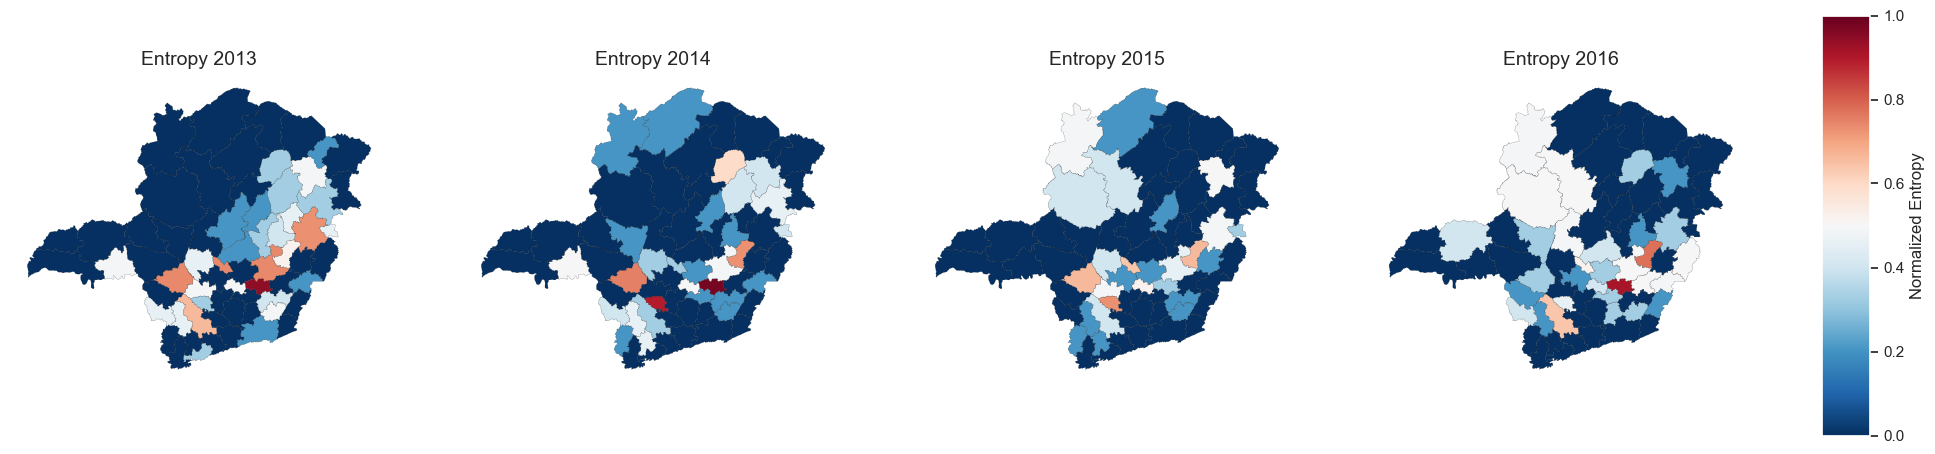

In [105]:
plot_normalized_entropy_maps(gdf_microregions, entropy_dictionary_microregions, years, city_col='microregion_index', save_path='plots/entropy_microregions.jpg')

## calculate cosine similarity

In [106]:
# import functions
%run Cosine_similarity_function.ipynb

In [107]:
# Collect all city vectors in order across all years
vector_microregion_months_list = []

for ye in years:
    vector_microregion_months_list.append(np.stack(list(vectors_flow_map_microregions[ye].values()), axis=-1))

# Concatenate along the month axis to create a (number_regions, 2, total_months) array
vectors_microregion_months = np.concatenate(vector_microregion_months_list, axis=-1)


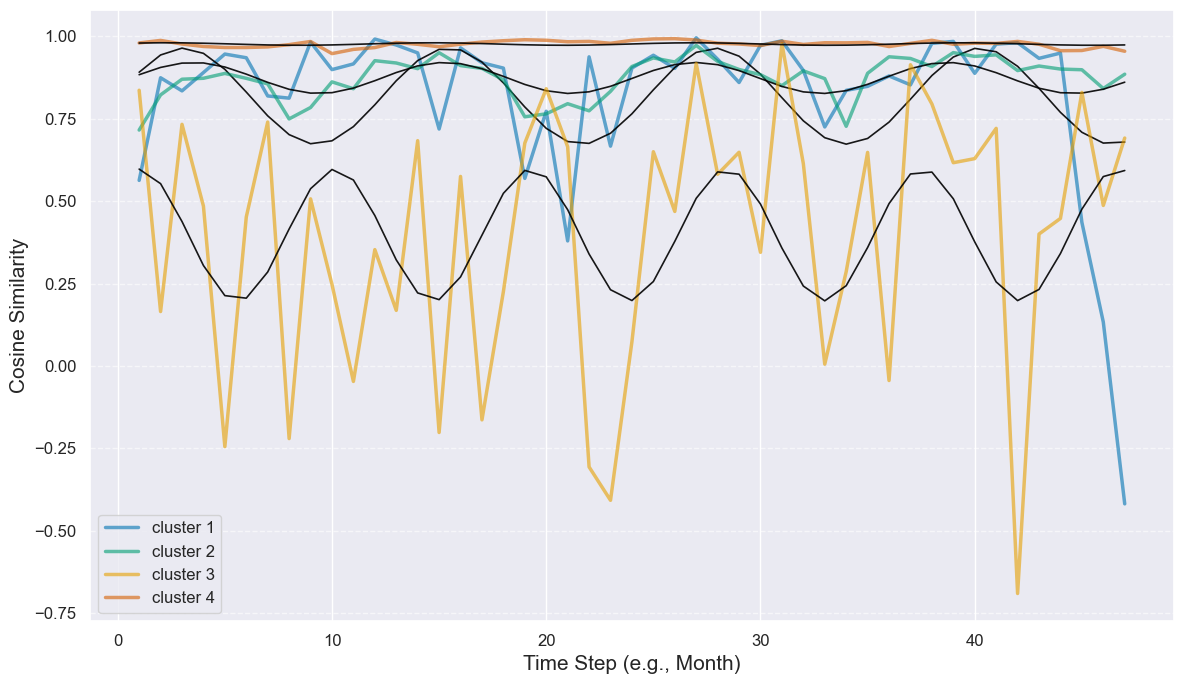

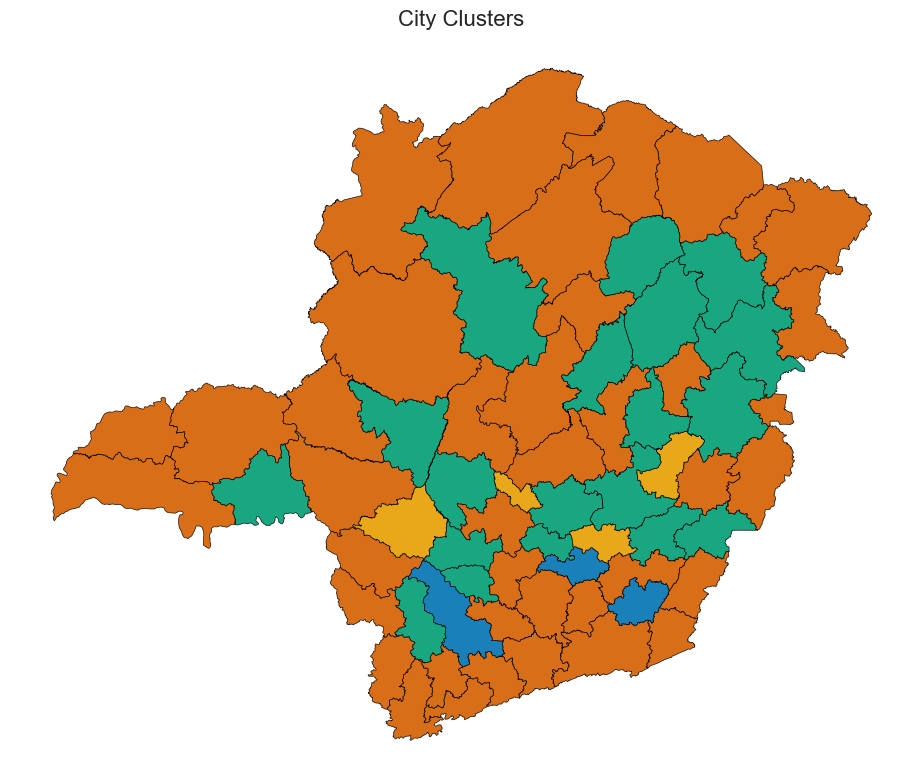

In [110]:
#Compute cosine similarity across the full 4-year period

vector_months_microregion_cosine_similarity = calculate_cosine_sim(vectors_microregion_months)


#calculate the distances between the cosine similarity values for the months for the regions
distance_matrix= calculate_dtw_distance_matrix(vector_months_microregion_cosine_similarity)

#cluster the regions(cities) based on the distance matrix
#select how many clusters you are interested to get
n_clusters=4
clusters, kmedoids= perform_kmedoids_clustering(distance_matrix, n_clusters)

#calculate the mean of the cosine similarity values of the regions(cities) in each clusters
clusters_mean= calculate_cluster_means(vector_months_microregion_cosine_similarity, clusters)

#plot clusters mean cosine similarity values for months and fit a curve
#assign color for clusters
cluster_colors = {
    0: "#0072b2",
    1: "#009e73",
    2: "#e69f00",
    3: '#d55e00',
    4:'#cc79a7'
}

plot_combined_cluster_trends(clusters_mean, cluster_colors, save_path='plots/CS_clusters_microregions_time_series', 
                             savgol_window=7, savgol_order=3)


plot_cluster_map(gdf_microregions, clusters, cluster_colors, cluster_id_col='cluster_id', city_num_col='microregion_index', 
                 save_path='plots/CS_clusters_microregions_map')

